# Paper Plots, Tables, Stats

## Sample Description

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use("opinionated_rc")

df = pd.read_parquet(
    "aligning_credit/data/files/matched-repo-contributors-to-authors.parquet"
)
df = df.astype({"publish_date": "datetime64[ns]"})

# TODO: remove this
# Temp remove orcid, position, and equal_contrib from "dev_not_author" rows
df.loc[df.author_dev_classification == "dev_not_author", "orcid"] = None
df.loc[df.author_dev_classification == "dev_not_author", "position"] = None
df.loc[df.author_dev_classification == "dev_not_author", "equal_contrib"] = None

# Rename author_dev_classification values
df["author_dev_classification"] = df["author_dev_classification"].replace(
    {
        "dev_author": "Author and Dev",
        "author_not_dev": "Author",
        "dev_not_author": "Dev",
    }
)

# Get dataframe of first row of each DOI group
df_doi_first = df.groupby("doi").first().reset_index()

print("N Unique Works (Papers and Repo Pairs):", len(df_doi_first))

N Unique Works (Papers and Repo Pairs): 1023


/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_64265/803940974.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df.author_dev_classification == "dev_not_author", "equal_contrib"] = None


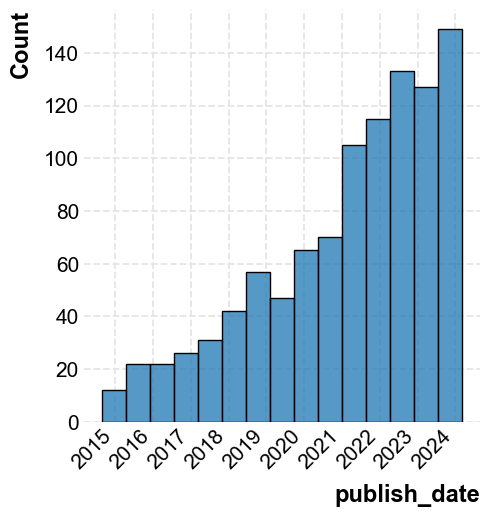

In [2]:
sns.displot(df_doi_first, x="publish_date")
_ = plt.xticks(rotation=45, ha="right")

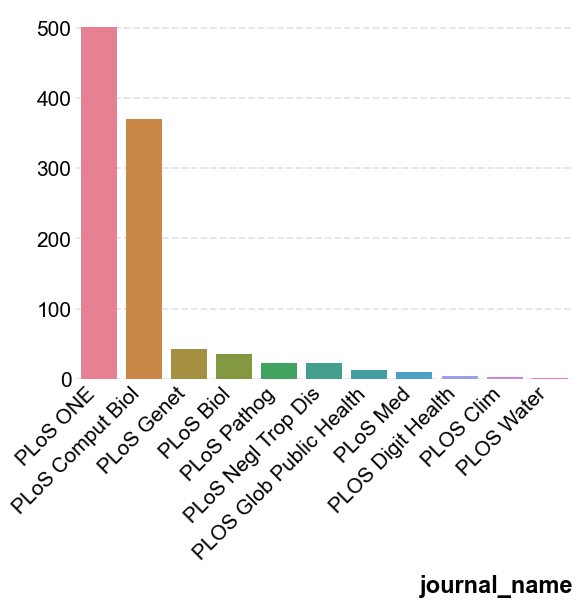

In [3]:
journal_counts = df_doi_first.journal_name.value_counts().sort_values(ascending=False)
sns.barplot(x=journal_counts.index, y=journal_counts.values, hue=journal_counts.index)
_ = plt.xticks(rotation=45, ha="right")

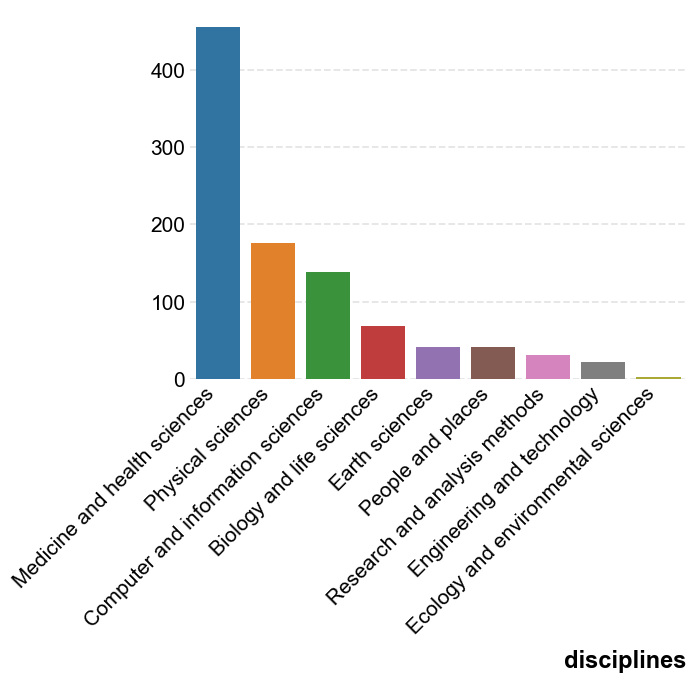

In [4]:
# Get the top level discipline for each DOI
discipline_counts = (
    df_doi_first.disciplines.apply(
        lambda x: x.split(";")[0] if isinstance(x, str) else None
    )
    .value_counts()
    .sort_values(ascending=False)
)
sns.barplot(
    x=discipline_counts.index, y=discipline_counts.values, hue=discipline_counts.index
)
_ = plt.xticks(rotation=45, ha="right")

## Authorship and Development

In [5]:
# Get a dataframe with the columns "doi", "author_dev_classification", and "count"
df_classification_counts = (
    df.groupby(["doi", "author_dev_classification"]).size().reset_index(name="count")
)

# Print describe stats (over author_dev_classification)
df_classification_counts.groupby("author_dev_classification").describe()

count                                              
                           count      mean       std  min  25%  50%  75%   max
author_dev_classification                                                     
Author                     985.0  4.553299  3.544928  1.0  2.0  4.0  6.0  28.0
Author and Dev             881.0  1.347333  0.758075  1.0  1.0  1.0  1.0   8.0
Dev                        312.0  3.487179  6.391300  1.0  1.0  1.0  2.0  30.0

<Axes: xlabel='author_dev_classification', ylabel='count'>

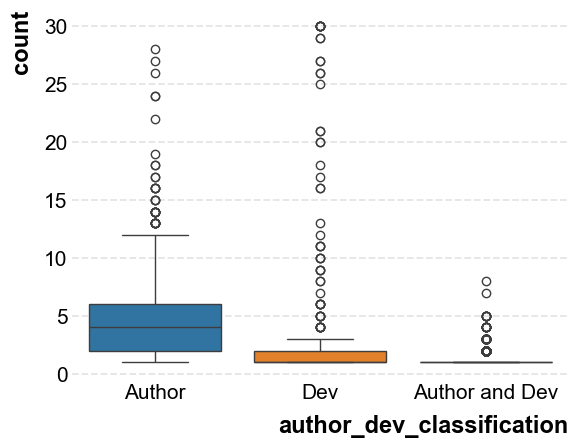

In [6]:
sns.boxplot(
    data=df_classification_counts,
    x="author_dev_classification",
    y="count",
    hue="author_dev_classification",
)

<Axes: xlabel='position'>

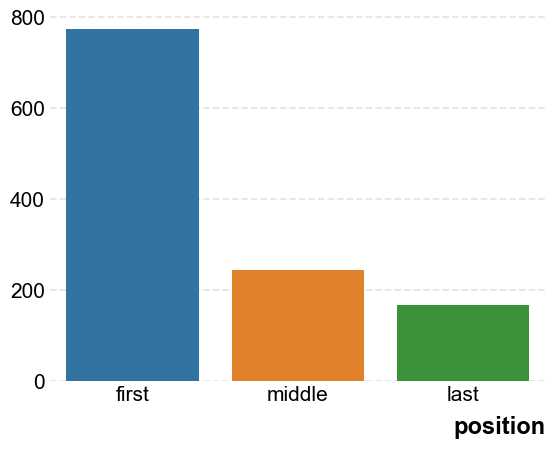

In [7]:
# Where are author-devs located
df_author_dev = df.loc[df.author_dev_classification == "Author and Dev"]
position_counts = df_author_dev.position.value_counts().sort_values(ascending=False)
sns.barplot(
    x=position_counts.index, y=position_counts.values, hue=position_counts.index
)

<Axes: xlabel='author_dev_classification', ylabel='position'>

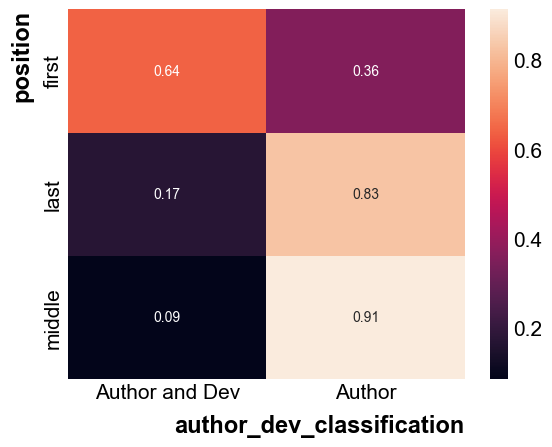

In [8]:
# Create a heatmap for the roles + classification proportion normalized per paper
# I.e. "what percent of authors in a single paper are the 'middle' position
# and are 'Author and Dev' vs 'Author' vs 'Dev'?"
positions_df_grouped = (
    df.groupby(["doi", "position", "author_dev_classification"])
    .size()
    .reset_index(name="count")
)
positions_df_grouped = positions_df_grouped.pivot(
    index=["doi", "position"], columns="author_dev_classification", values="count"
)
positions_df_grouped = positions_df_grouped.div(
    positions_df_grouped.sum(axis=1), axis=0
)
positions_df_grouped = positions_df_grouped.reset_index().fillna(0)
positions_df_grouped = positions_df_grouped.groupby("position").agg(
    {"Author and Dev": "mean", "Author": "mean"}
)
sns.heatmap(positions_df_grouped, annot=True, fmt=".2f")

<Axes: >

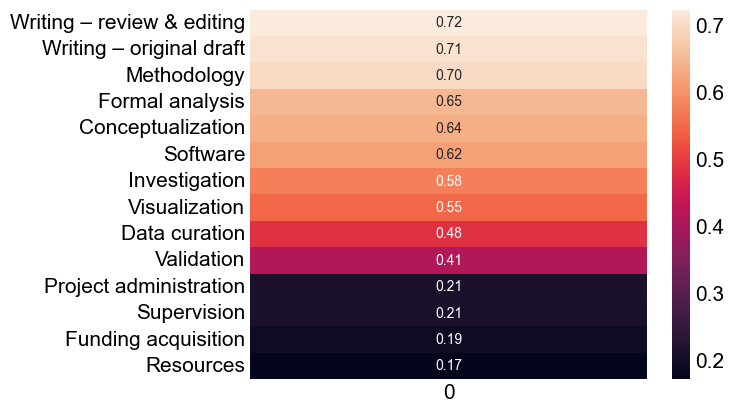

In [9]:
# What roles do authors and devs take on
only_author_devs = df.loc[df.author_dev_classification == "Author and Dev"]
author_dev_roles = only_author_devs.roles.str.get_dummies(";")
author_dev_roles = pd.concat(
    [only_author_devs[["doi", "author_dev_classification"]], author_dev_roles], axis=1
)
author_dev_roles = (
    author_dev_roles.drop(columns=["doi", "author_dev_classification"])
    .mean()
    .sort_values(ascending=False)
)
sns.heatmap(author_dev_roles.to_frame(), annot=True, fmt=".2f")

<Axes: xlabel='author_dev_classification', ylabel='role'>

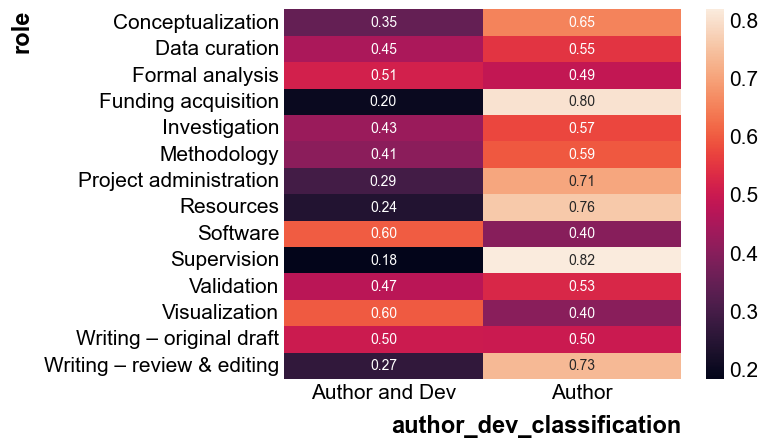

In [10]:
# Create a heatmap for the roles + classification proportion normalized per paper
# The "roles" column is currently a ";" separated string of roles,
# make each role its own column with a binary flag
# Also, we will never have rows for "Dev" contributors so remove them
# I.e. "what percent of authors in a single paper contributed to
# 'Data curation' roles and are 'Author and Dev' vs 'Author' vs 'Dev'?"
no_devs = df[df.author_dev_classification != "Dev"]
roles_df = no_devs.roles.str.get_dummies(";")
roles_df = pd.concat([no_devs[["doi", "author_dev_classification"]], roles_df], axis=1)

# Go to long format with "role" as a new column
roles_df_long = roles_df.melt(
    id_vars=["doi", "author_dev_classification"], var_name="role", value_name="count"
)

# Drop any rows where the count is 0
roles_df_long = roles_df_long[roles_df_long["count"] > 0]

# Continue with the heatmap
roles_df_long = roles_df_long.pivot_table(
    index=["doi", "role"],
    columns="author_dev_classification",
    values="count",
    aggfunc="sum",
)
roles_df_long = roles_df_long.div(roles_df_long.sum(axis=1), axis=0)
roles_df_long = roles_df_long.reset_index().fillna(0)
roles_df_long = roles_df_long.groupby("role").agg(
    {"Author and Dev": "mean", "Author": "mean"}
)
sns.heatmap(roles_df_long, annot=True, fmt=".2f")

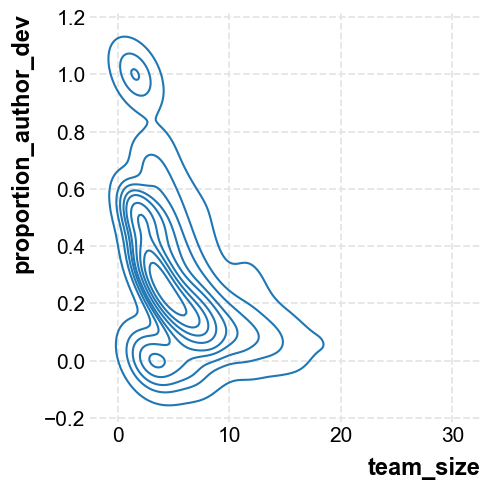

In [11]:
# Create a kde distribution plot
# with team size on the x-axis
# and the proportion of author and dev contributors on the y-axis
rows = []
for doi, group in df.groupby("doi"):
    n_non_devs = len(
        group[group.author_dev_classification.isin(["Author", "Author and Dev"])]
    )

    rows.append(
        {
            "doi": doi,
            "team_size": n_non_devs,
            "proportion_author_dev": len(
                group[group.author_dev_classification == "Author and Dev"]
            )
            / n_non_devs,
        }
    )

team_size_df = pd.DataFrame(rows, columns=["doi", "team_size", "proportion_author_dev"])
sns.displot(team_size_df, x="team_size", y="proportion_author_dev", kind="kde")

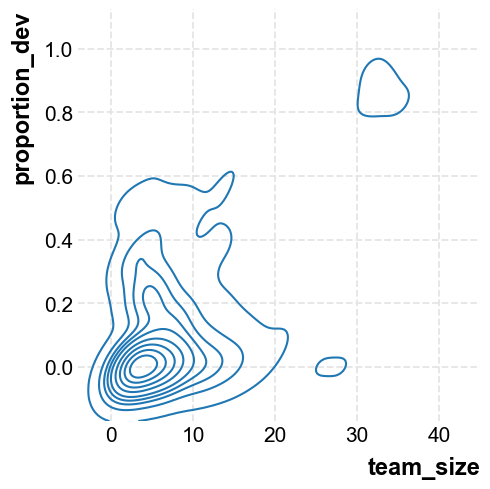

In [12]:
# Create a kde distribution plot
# with team size on the x-axis
# and the proportion of devs on the y-axis
rows = []
for doi, group in df.groupby("doi"):
    n_devs = len(group[group.author_dev_classification == "Dev"])

    rows.append(
        {
            "doi": doi,
            "team_size": len(group),
            "proportion_dev": n_devs / len(group),
        }
    )

team_size_df = pd.DataFrame(rows, columns=["doi", "team_size", "proportion_dev"])
sns.displot(team_size_df, x="team_size", y="proportion_dev", kind="kde")